In [1]:
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

### Fig 3. The vote distribution of functional modules

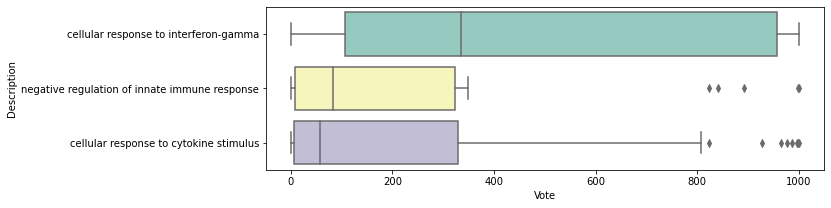

In [11]:
module_vote = pd.DataFrame()
ppi = 'GRN'
functional_module_path = '/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/'
ppi_xl = pd.ExcelFile(functional_module_path + 'Summary_table_of_%s_FunModu.xlsx' % ppi)
sheet = 'hbv_only_35'
np_ratio = 35

df = ppi_xl.parse(sheet)
exp_m = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/%s_coding_gene_std_by_gene_with_synthetic.txt" % sheet[:-3],sep='\t',index_col=0)
vote_np = np.load("/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/with_synthetic/%s_std_by_gene/%s_std_by_gene__vote_np_ratio_%d.npy" % (sheet[:-3],sheet[:-3],np_ratio))
vote_series = pd.Series(vote_np,index=exp_m.index)

for idx in range(df.shape[0]) :
    nodes = df["Nodes"][idx].split("_")
    vote = vote_series[nodes].values
    des = [df["Description"][idx]] * len(nodes)
    tmp = pd.DataFrame({'Description' : des,'Gene' : nodes,'Vote' : vote})
    module_vote = pd.concat([module_vote,tmp])
### rename high length go term
rename_dict = {'antigen processing and presentation of endogenous peptide antigen via MHC class I' : 
               'antigen processing and presentation of endogenous peptide antigen\nviaMHC class I',
               'antigen processing and presentation of endogenous peptide antigen via MHC class I via ER pathway':
               'antigen processing and presentation of endogenous peptide antigen\nviaMHC class I via ER pathway',
               'antigen processing and presentation of endogenous peptide antigen via MHC class I via ER pathway, TAP-independent':
               'antigen processing and presentation of endogenous peptide antigen\nvia MHC class I via ER pathway, TAP-independent',
               'regulation of adaptive immune response based on somatic recombination of immune receptors built from immunoglobulin superfamily domains':
               'regulation of adaptive immune response based on somatic recombination of\nimmune receptors built from immunoglobulin superfamily domains'}
module_vote['Description'].replace(rename_dict,inplace=True)

plt.figure(figsize=(10,3))
sns.boxplot(data=module_vote,x='Vote',y='Description',palette="Set3",order=module_vote.groupby('Description').agg('median').sort_values(by='Vote',ascending=False).index)
plt.legend([], [], frameon=False)
fig_output_path = "/home/bruce1996/data/LIHC_anomaly_detection/manuscript/Fig3_functional_module_vote_distribution/%s_module_%s_vote_boxplot.svg" % (ppi,sheet.split("_")[0])
plt.savefig(fig_output_path,dpi=300,bbox_inches='tight',format='svg')

### Fig4. Functional module gene interaction network

In [19]:
from itertools import count
from math import log10
from random import randint
from matplotlib.colors import rgb2hex


def edge2node(edge_context) :
    '''
    edge_list : str, like 'ENSG00000115415 ENSG00000138496_ENSG00000115415 ENSG00000168961_ENSG00000115415, underline as seperator
    '''
    edge_l = edge_context.split('_')
    node_l = set(list(map(lambda x : x.split(' ')[0],edge_l)) + list(map(lambda x : x.split(' ')[1],edge_l)))
    return list(node_l)

def construct_module_interaction_network(node_list,edge_list,go_term,go_description) :
    """_summary_
    Args:
        node_list (list): which node exists in network
        edge_list (list): which edge exists in network
        go_term (str): GO acession number of network
        go_description (str): GO description of network
    """    
    g = nx.Graph()
    edges = [(x.split(' ')[0],x.split(' ')[1]) for x in edge_list]
    g.add_nodes_from(node_list)
    g.add_edges_from(edges)
    ### add attribute to node
    go_dict = {}
    des_dict = {}
    for node in node_list :
        go_dict[node] = go_term
        des_dict[node] = go_description
    nx.set_node_attributes(g,go_dict,name='GO')
    nx.set_node_attributes(g,des_dict,name='Description')

    return g

def construct_global_interaction_network(module_xl,sheet_name) :
    '''
    module_xl : pd.ExcelFile; contain functional module information
    sheet_list : list; which sheet will be used to construct network
    '''
    g = nx.Graph()
    node_dict = {}
    description_dict = {}
    node_description = {}
    df = module_xl.parse(sheet_name)
    for i in range(df.shape[0]):
        go = df.loc[i,'GOID']
        description_dict[go] = df.loc[i,'Description']
        edge = df.loc[i,'Edges']
        nodes = edge2node(edge)
        for n in nodes :
            node_dict[n] = go
            node_description[n] = description_dict[go]
            edge_list = [(x.split(' ')[0],x.split(' ')[1],{'GO' : go,'Condition' : sheet_name}) for x in edge.split('_')]
            g.add_edges_from(edge_list)
    nx.set_node_attributes(g,node_dict,name='GO')
    nx.set_node_attributes(g,node_description,name='Description')
    
    return g

def remove_edges_without_candidate_gene(g,candidate_genes,mode='union') :
    rm_list = []
    for gene1,gene2 in g.edges :
        if mode == 'union' :
            if gene1 not in candidate_genes and gene2 not in candidate_genes :
                rm_list.append((gene1,gene2))
        else :
            if gene1 not in candidate_genes or gene2 not in candidate_genes :
                rm_list.append((gene1,gene2))

    g.remove_edges_from(rm_list)
    #remoev node without any edge
    for node in list(g.nodes) :
        if g.degree[node] == 0 :
            g.remove_node(node)

def remove_zero_degree_node(g):
    for node in list(g.nodes) :
        if g.degree[node] == 0 :
            g.remove_node(node)

def plot_gene_interaction_network(g,ens2hgsc,output_path,weight=None,degree_threshold=10,hue='GO',cmap=plt.cm.Set3,format='svg',title="",fig_size = (20,12)) :
    """_summary_

    Args:
        g (nx.graph): input interaction network
        ens2hgsc (dict): a ens gene to HGNC symbol convertor
        output_path (str): output path of fig
        weight (str, optional): Which attribute in g as weight of node size. Defaults to None.
        degree_threshold (int, optional): Node with degree above this threshold will be annotated. Defaults to 10.
        hue (str, optional): Which atribute in g as color of node. Defaults to 'GO'.
        cmap (_type_, optional): Defaults to plt.cm.Set3.
        title (str, optional): Defaults to "Gene interaction network".
        fig_size (tuple, optional): Defaults to (20,12).
    """    
    # get unique groups
    groups = set(nx.get_node_attributes(g,hue).values())
    mapping = dict(zip(sorted(groups),count()))
    nodes = g.nodes()
    if len(mapping) == 1 :
        rgba = cmap(randint(0,10))
        colors = rgb2hex(rgba)
    else :
        colors = [mapping[g.nodes[n][hue]] for n in nodes]

    plt.figure(figsize=fig_size)
    pos = nx.kamada_kawai_layout(g,dim=2)
    values = []
    for x in list(g.nodes) :
        if g.degree[x] == 0 :
            degree = 100
        else :
            degree = g.degree[x] * 100 
        if weight :
            if g.nodes[x][weight] == 0 :
                weighting = 1
            else :
                weighting = log10(g.nodes[x][weight])
            values.append(degree * weighting)
        else :
            values.append(degree)

    labels = {}
    for key,val in g.degree() :
        if val >= degree_threshold and key in pos:
            labels[key] = ens2hgsc[key] + "\n(%d)" % g.nodes[key]['Vote']
        
    nx.draw_networkx_nodes(g, pos, cmap=cmap, node_size = values,node_color=colors)
    nx.draw_networkx_labels(g,pos, labels)
    nx.draw_networkx_edges(g, pos,alpha=0.2)
    
    # remove legend when only one GO exist
    if len(mapping) > 1 :
        for key,val in mapping.items():
            plt.scatter([],[], c=[cmap(val/(max(colors)+1))], label='{}'.format(key))    

        plt.legend(bbox_to_anchor=(1,1))
        
    plt.title(title)
    plt.savefig(output_path,bbox_inches='tight',dpi=300,format=format)

In [16]:
with open("/home/bruce1996/data/LIHC_anomaly_detection/data/coding_gene_info/hgnc2ensembl.pkl",'rb') as f :
    hgsc2ens = pickle.load(f)
f.close()
ens2hgsc = {}
for hgsc,ens in hgsc2ens.items() :
    ens2hgsc[ens] = hgsc

In [21]:
functional_module_path = '/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/'
vote_path = '/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/ensemble_learning_result/'
condition = [('hbv_only',35)]
ppi = 'PIN'
ppi_xl = pd.ExcelFile(functional_module_path + 'Summary_table_of_%s_FunModu.xlsx' % ppi)

module_network = {'hbv_only' : {},'tumor_only' : {}}
module_genes_dict = {}
for sheet,np_ratio in condition :
    df = ppi_xl.parse(sheet + '_' + str(np_ratio))
    vote = pd.read_csv(vote_path + 'ensemble_%s_np_ratio_%d_vote_result.txt' % (sheet,np_ratio),sep='\t',index_col=0)
    for idx in range(df.shape[0]) :
        go = df['GOID'][idx]
        des = df['Description'][idx]
        edge_list = df['Edges'][idx].split('_')
        node_list = df['Nodes'][idx].split('_')
        module_network[sheet][des] = construct_module_interaction_network(node_list,edge_list,go,des)
        vote_dict = dict(zip(node_list,list(vote.loc[node_list,'Vote'].values)))
        hallmark_dict = dict(zip(node_list,list(vote.loc[node_list,'Label'].values)))
        nx.set_node_attributes(module_network[sheet][des] ,vote_dict,name='Vote')
        nx.set_node_attributes(module_network[sheet][des] ,vote_dict,name='Vote')


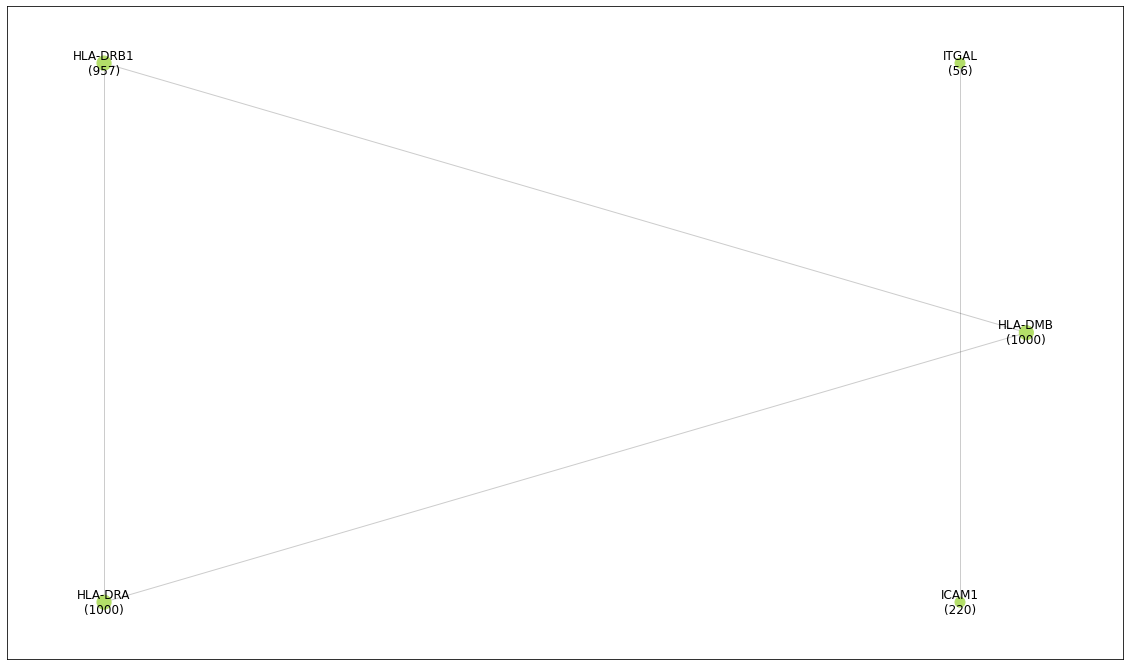

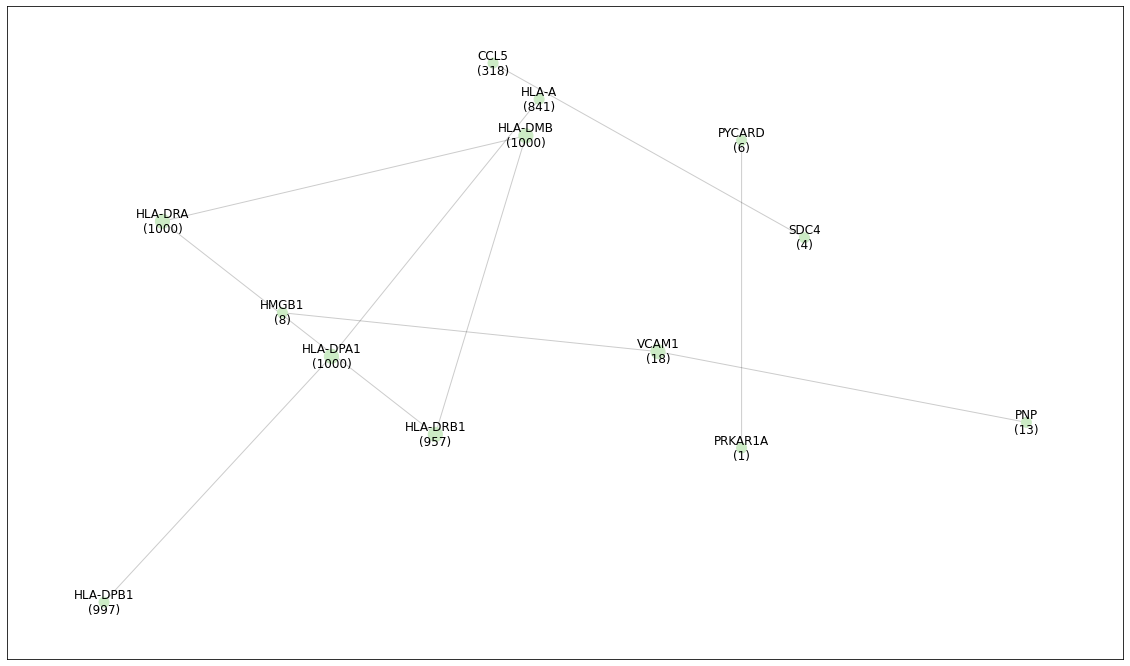

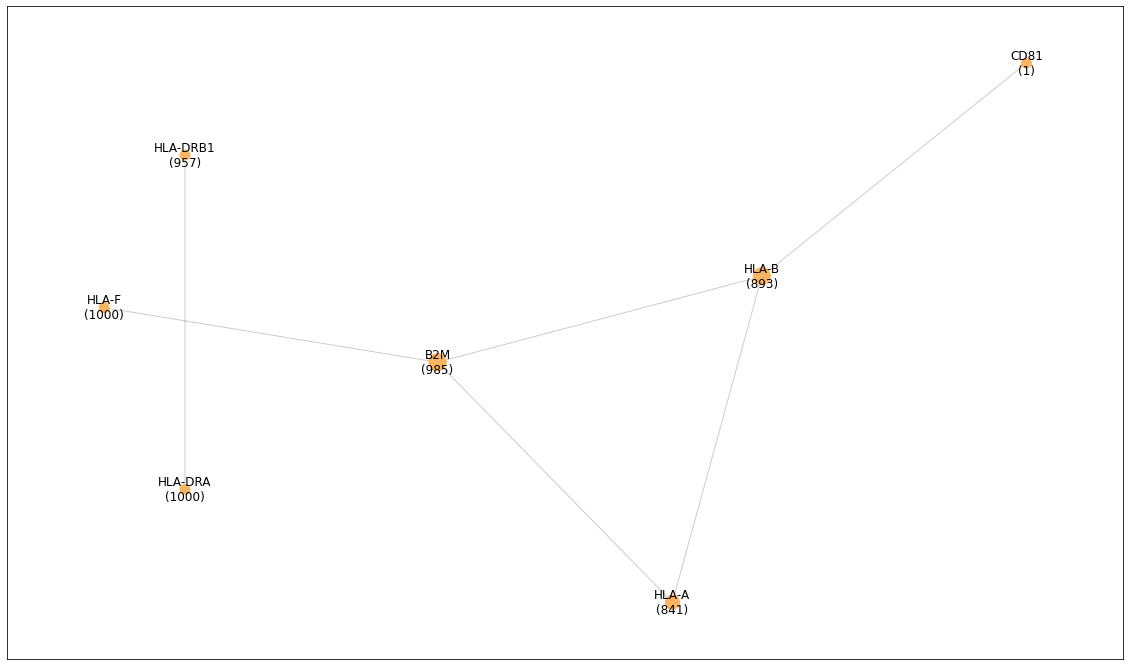

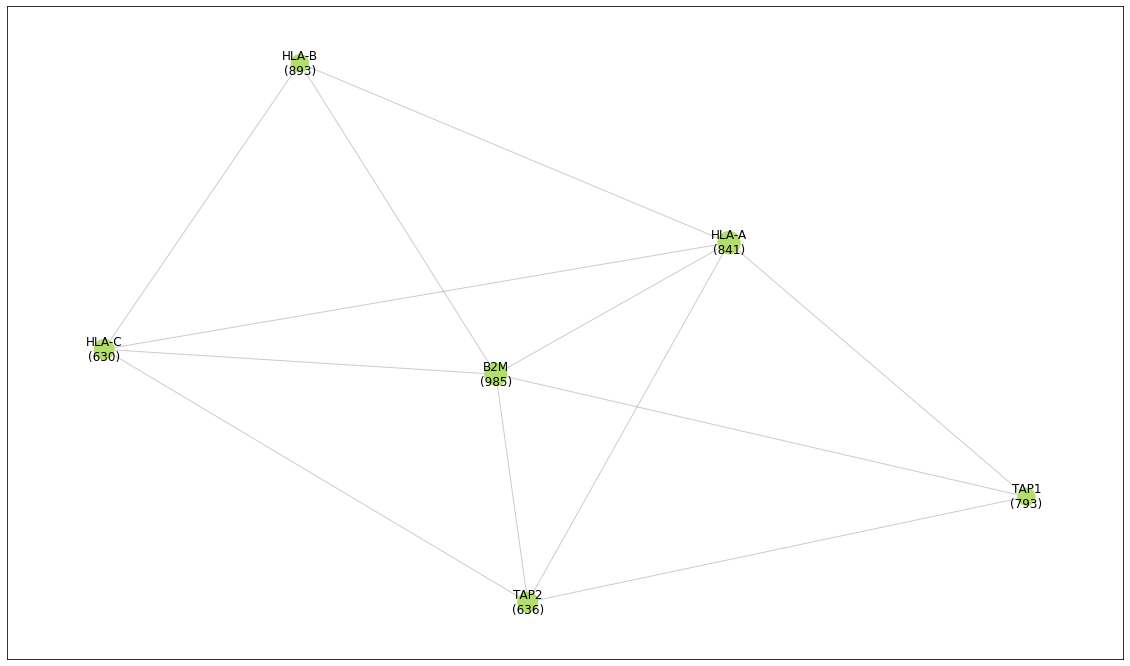

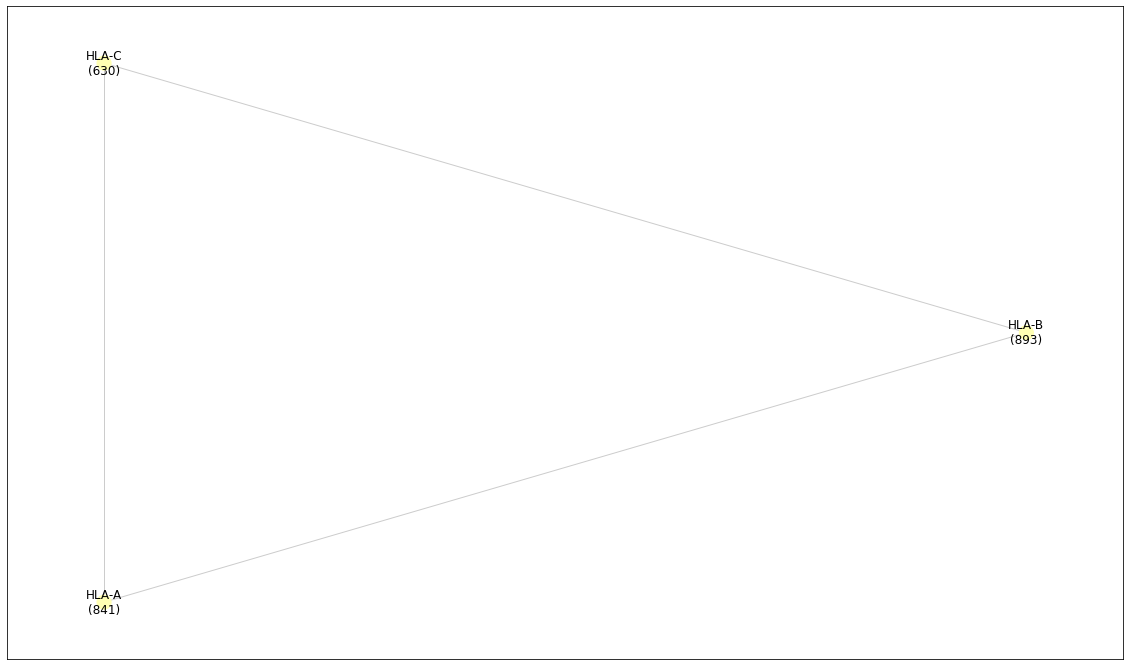

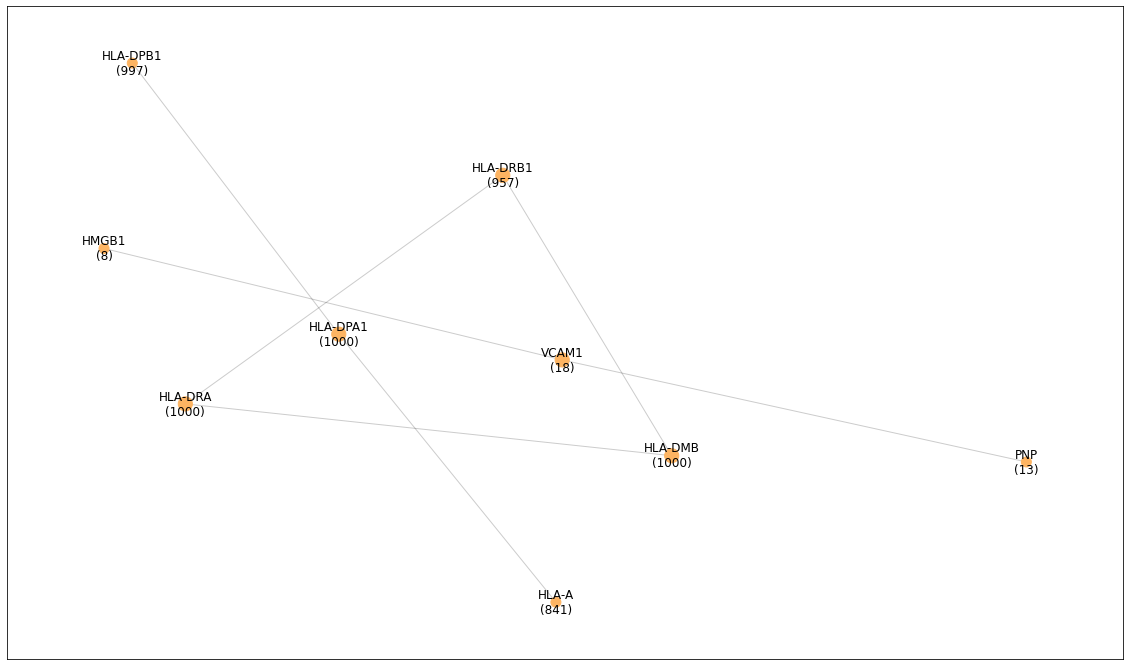

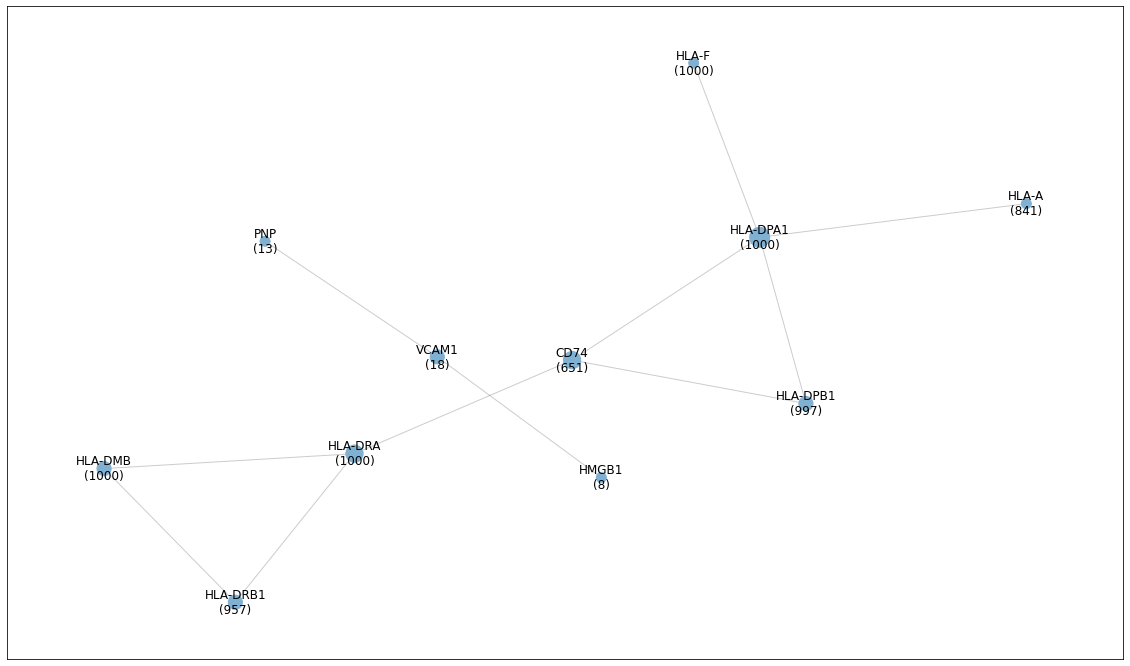

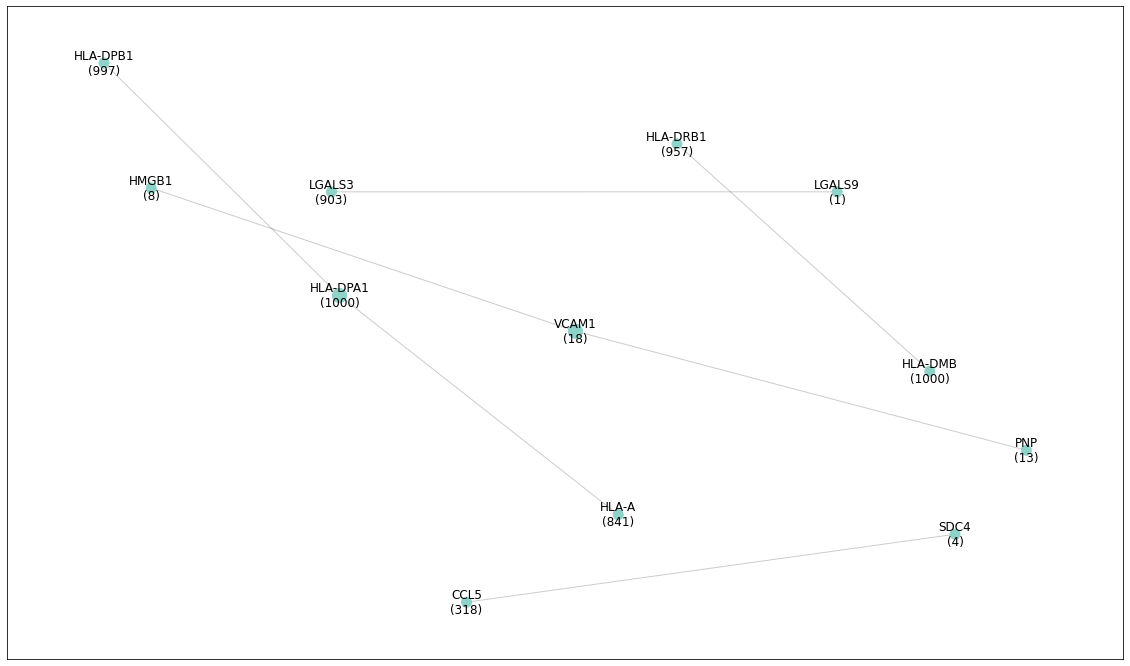

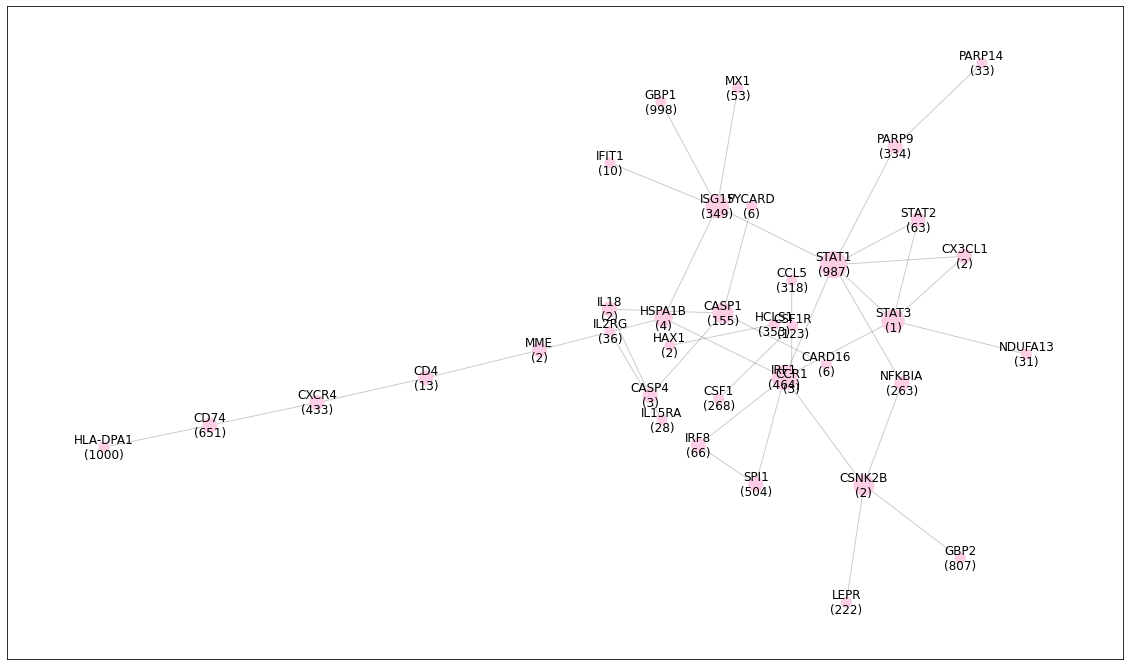

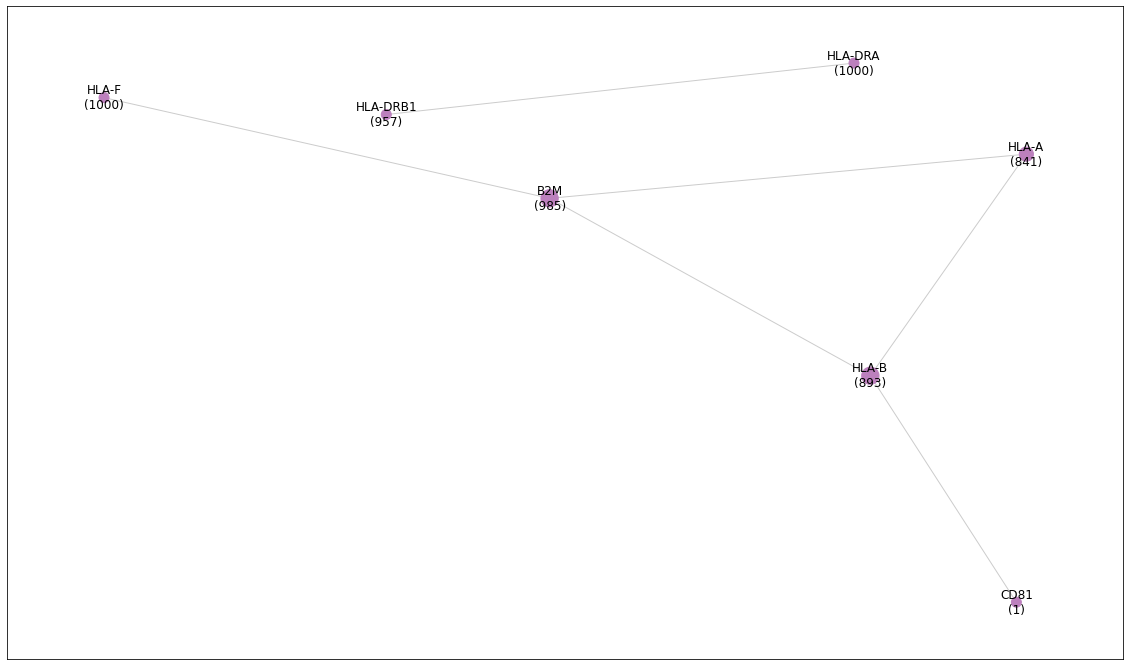

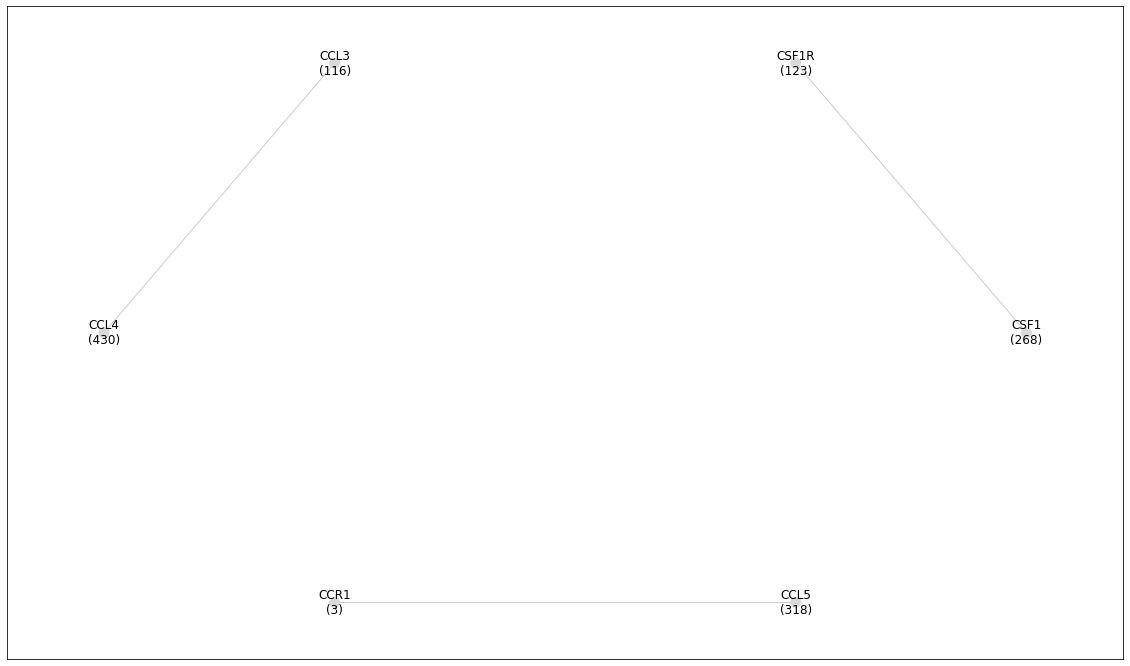

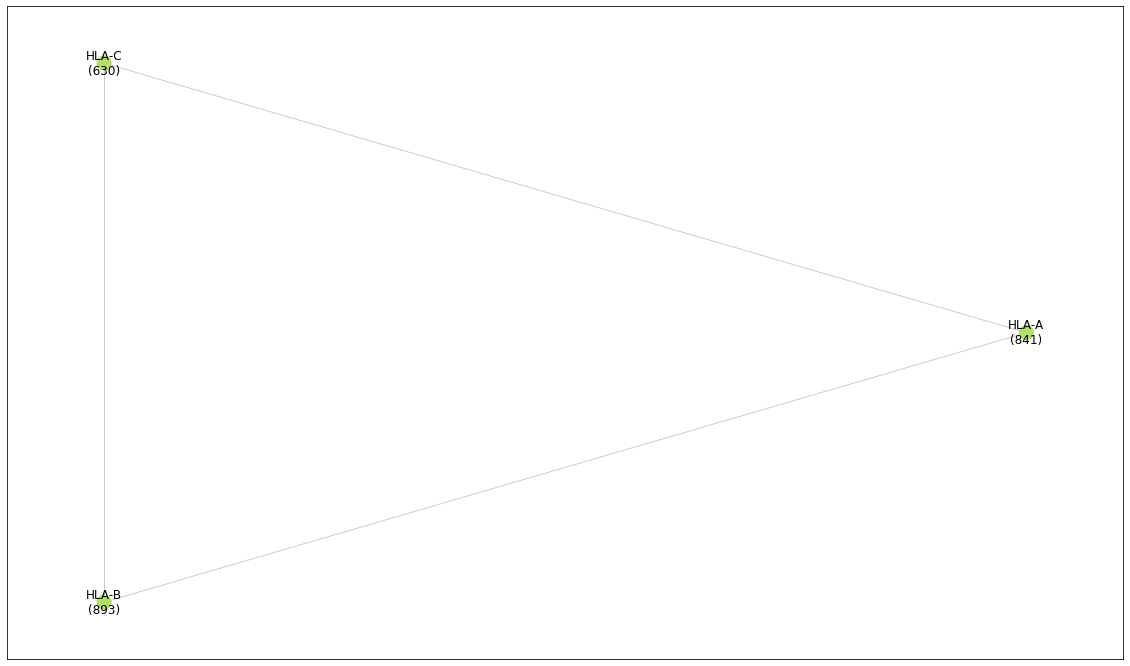

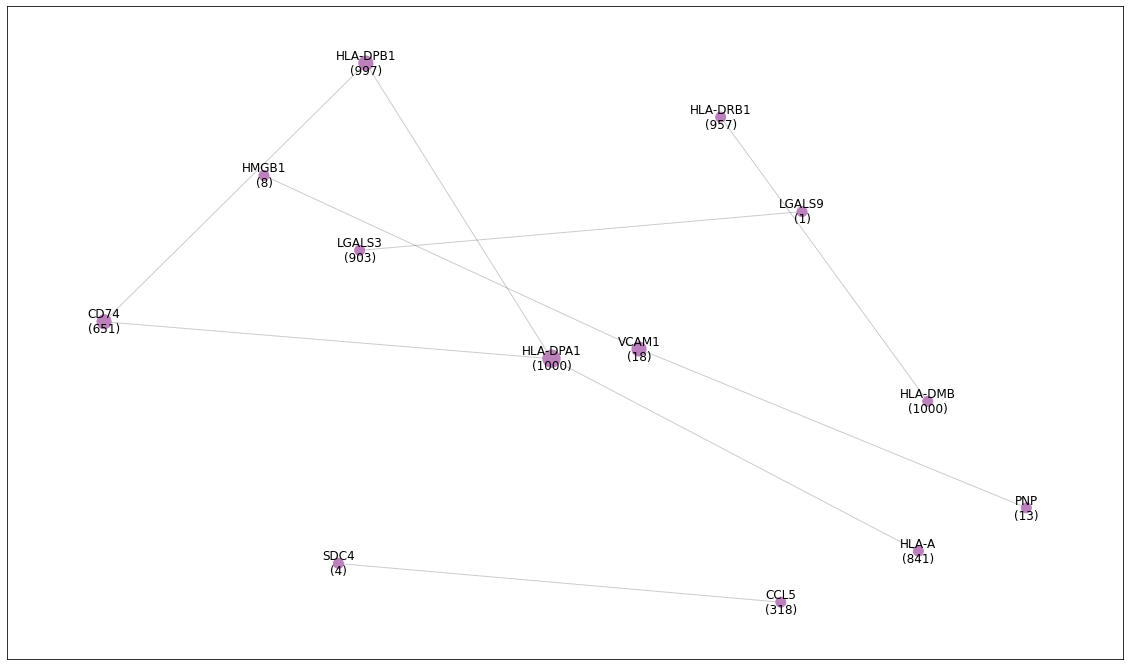

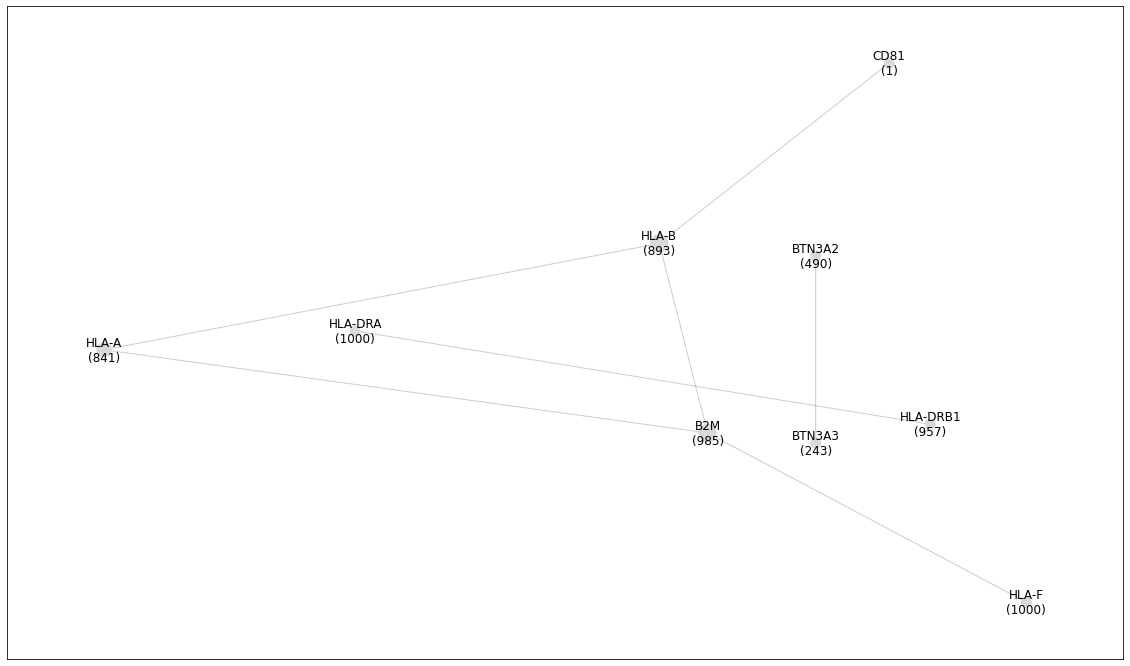

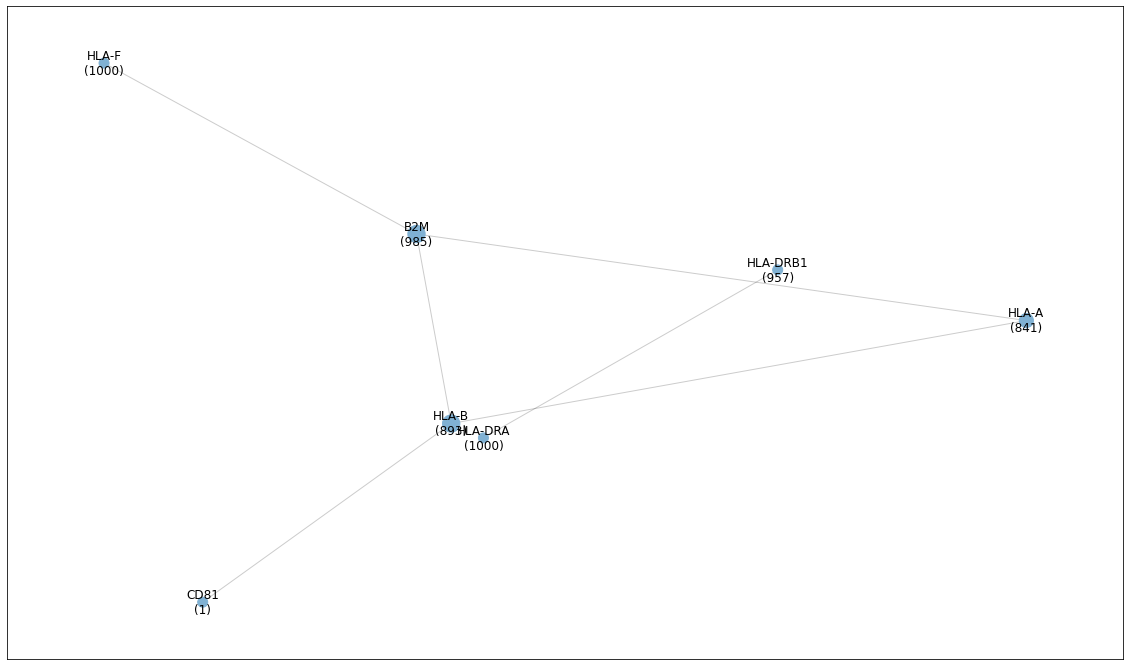

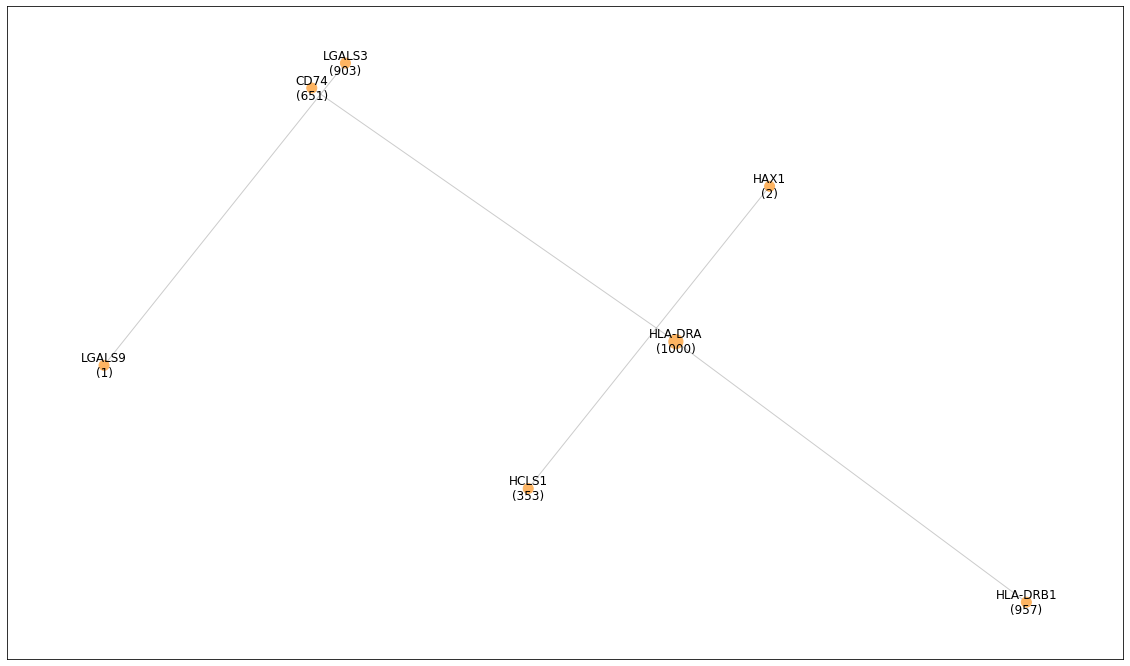

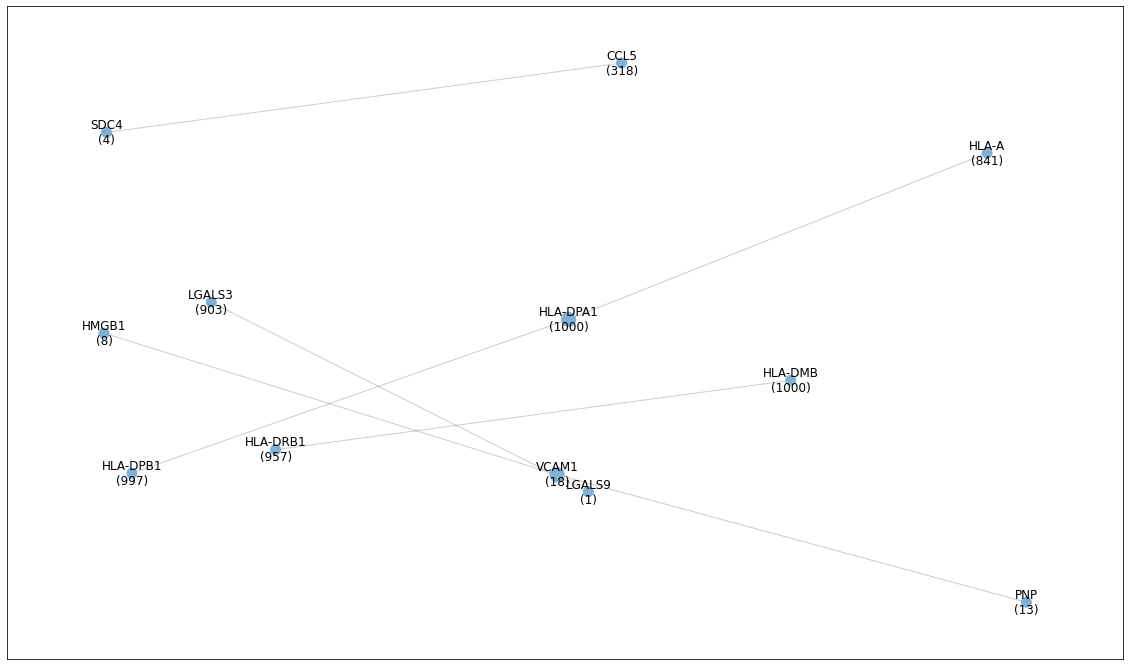

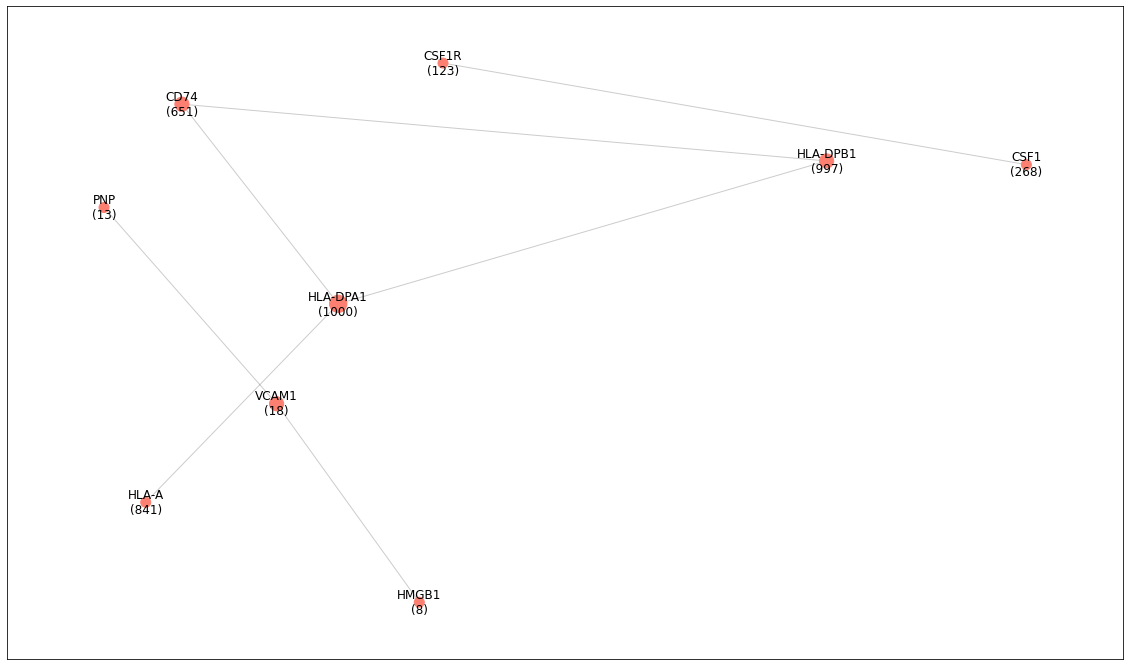

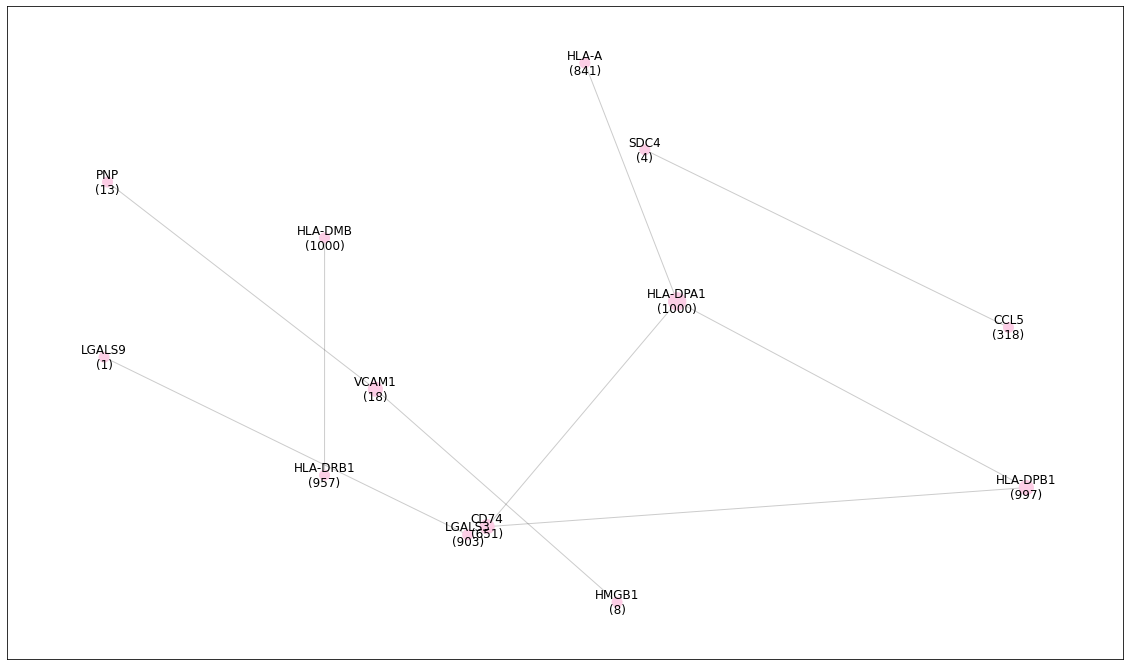

In [22]:
fig_path = '/home/bruce1996/data/LIHC_anomaly_detection/manuscript/Fig4_module_gene_interaction_network/'
for sheet in module_network :
    fig_output_path = fig_path + ppi + '_' + sheet + '/'
    for module in module_network[sheet] :
        g = module_network[sheet][module]
        remove_zero_degree_node(g)
        if len(g.nodes) > 50 :
            plot_gene_interaction_network(g,ens2hgsc,fig_output_path + module.replace(' ','_') + '.svg',degree_threshold=3)
        else :
            plot_gene_interaction_network(g,ens2hgsc,fig_output_path + module.replace(' ','_') + '.svg',degree_threshold=1)